# **Bioinformatic Approach to Facilitate the Transcriptome analysis of *Trypanosoma congolense***   

**Authors: Lucy Sibbring (2311385), Lucas Walker (1930864), Yilong Yang (2237985)**

# Background

Trypanosoma congolense is a widespread pathogen, primarily responsible for animal trypanosomiasis, commonly known as nagana or sleeping sickness. T. congolense has severe effects on African livestock and consequently has a significant socio-economic impact, making it an important parasite to research. The life cycle of T. congolense is split into two broad phases, one in the tsetse fly vector and the other in the host mammal’s bloodstream. A tsetse fly infected with metacyclic trypomastigotes injects the parasite into the bloodstream of the host, where metacyclic trypomastigotes become bloodstream trypomastigotes. Here they multiply (in various body fluids) and then actively circulate in the blood. When a tsetse fly takes a blood meal from the host animal, it becomes infected with the bloodstream trypomastigote which enters the midgut of the fly and differentiates into the procyclic stage. Further replication by binary fission occurs then procyclic trypomastigotes escape the midgut and enter the epimastigote stage where they continue to multiply within the salivary glands of the tsetse fly vector, then lastly, the trypomastigotes transform back into the infective metacyclic form. This cycle typically takes around 3 weeks. 

# Introduction

In this project, we are using expressed sequence tag (EST) data taken from each developmental stage in the T. congolense life cycle. ESTs are relatively small fragments of mRNA sequences (no longer than 500 nucleotides) typically found at the ends of expressed genes and facilitate a relatively quick and cost-effective method of gene discovery in comparison to whole genome sequencing (WGS). Our approach here takes the form of a pipeline of analysis for EST data to create a set of prepared and processed data suitable for further biological analysis. We aim for this pipeline to be accessible to those who might be less familiar with bioinformatic analyses and provide detailed instructions to aid those wanting to replicate the analysis on future EST datasets from T. congolense. To achieve this, each step of the analysis will be explained in sufficient detail from start to finish, explaining the different outputs and how the code functions, to keep things tidy all code can be found within a single file in the archive.  

As a general outline, this manual will first explore downloading the raw EST data from a public library and then using the program TransDecoder to generate the open reading frames (ORFs) and coding protein sequences (CDS) from these ORFs. Next, the code will be introduced where there are two main functions, the first will be running a function to rename each protein sequence into a human-readable format and then running a function to retrieve specific sequences based on an identifier (ID). Some of our findings will also be included towards the end.

# Prequisites (Windows/Linux)
* Ubuntu 22.04.1 LTS
* Python 3.10.6 (64-bit)
* JupyterLab 3.3.2
* Biopython 1.80
* Pytest 7.1.3

Update all packages in Ubuntu through the command line: `sudo apt update`

Download python3 in ubuntu through command line: `sudo apt install python3`

Allow python to run on the ubuntu command line: `sudo apt install python3-pip`

Download pytest in ubuntu through command line: `sudo pip3 install pytest`

Download Biopython in ubuntu through command line: `sudo pip3 install biopython`

# Accessing EST Data

To download the *T. congolense* EST database we navigated to the website (http://www.sanger.ac.uk/Projects/T_congolense/EST_index.shtml) (2). On this page, under the header "Data Downloads" there is a link to the FTP site. To access these files easily, we right-clicked on the link and copied the link (ftp://ftp.sanger.ac.uk/pub/project/pathogens/Trypanosoma/congolense/). We then opened up our File Explorer and pasted the link into the file path bar shown below and pressed enter.

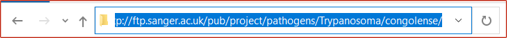

This opened the folder which contained the "ESTs" data folder which we copied. We then created a working directory in Ubuntu (`mkdir trypanosoma_congolense`) and navigated inside this folder (`cd trypanosoma_congolense`). To open up the working directory in File Explorer we ran `explorer.exe .` on the command line and then pasted the ESTs folder in `trypanosoma_congolense`.

We navigated to the ESTs folder in Ubuntu from the current working directory, `trypanosoma_congolense`, by `cd ESTs`. To visualise the files in the EST folder we ran `ls` in the command line and saw that the files had a .fas.gz extension (Figure 1) which meant they were zipped. 

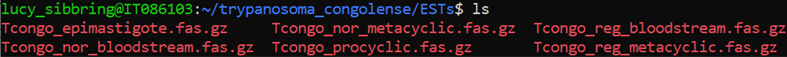

*Figure 1: ESTs folder .fas.gz extension files*

To unzip all the files in the current ESTs folder at once we ran `gzip -d *` in the command line which changed the files so that they now had just the .fas extension (Figure 2).

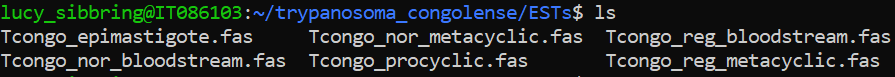

*Figure 2: ESTs folder containing .fas extension files*

# Using TransDecoder to Predict Coding Regions

In  order to predict the coding regions of the EST data we used the TransDecoder package (3). TransDecoder predicts the most likely, unique coding regions across all reading frames of the fasta sequences and can be used as a starting point to identify expressed genes. To download the TransDecoder package in Ubuntu we ran `sudo apt-get install transdecoder` on the command line (Figure 3). TransDecoder first extracts the long open reading frames (ORFs) from the transcript fasta files and then predicts the likely coding regions from these long ORFs. 



*Figure 3: code to download Transdecoder in Ubuntu*

TransDecoder is unable to predict coding regions from sequences that contain ambiguous characters (i.e. "-" for missing/undetermined bases in transcriptomic data): it produces an error and halts execution of the code on the rest of the sequences. It can however accept "N" as an unknown base and will skip over sequences which contains this character as there isn't enough data to accurately predict the coding region. To edit the fasta files we ran the following code in the command line:

`sed -e "/^[^>]/s/-/N/g" Tcongo_file.fas > Tcongo_file.adj.fas `

This replaces all the "-" characters in the sequences by "N" in the Tcongo file specified, but does not alter the fasta file headers. This is useful since we don't want to change the fasta sequence names at this stage and fasta headers can contain "-". It saves these edited sequences to a new fasta file with the same name but an additional extension ".adj".

Example: `sed -e "/^[^>]/s/-/N/g" Tcongo_epimastigote.fas > Tcongo_epimastigote.adj.fas`

To generate the long ORFs first, we followed the wiki page on TransDecoder's GitHub page (3) and ran the following in the command line for each of the edited fasta files with the ".adj.fas" extension:
`TransDecoder.LongOrf -t Tcongo_file.adj.fas`

Example: `TransDecoder.LongOrf -t Tcongo_epimastigote.adj.fas`

Then, to generate the coding sequences, we ran:
`TransDecoder.Predict -t Tcongo_file.adj.fas`

Example: `TransDecoder.Predict -t Tcongo_epimastigote.adj.fas`

These two operations produced output files with "adj.fas.transdecoder." extensions followed by "bed", "pep", "cd" and "gff3" (Figure 4). From these, we are only interested in the files with the "pep" extension since these contain our predicted peptide coding sequences (Figure 5) from our EST data. The contents of the other output files can be found on the TransDecoder GitHub wiki page (3).

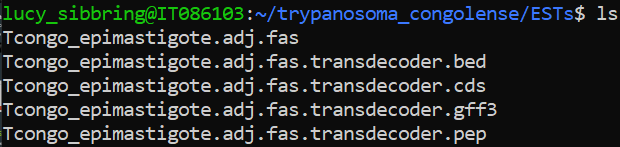

*Figure 4: files produced by applying the TransDecoder functions to Tcongo_epimastigote.adj.fas*

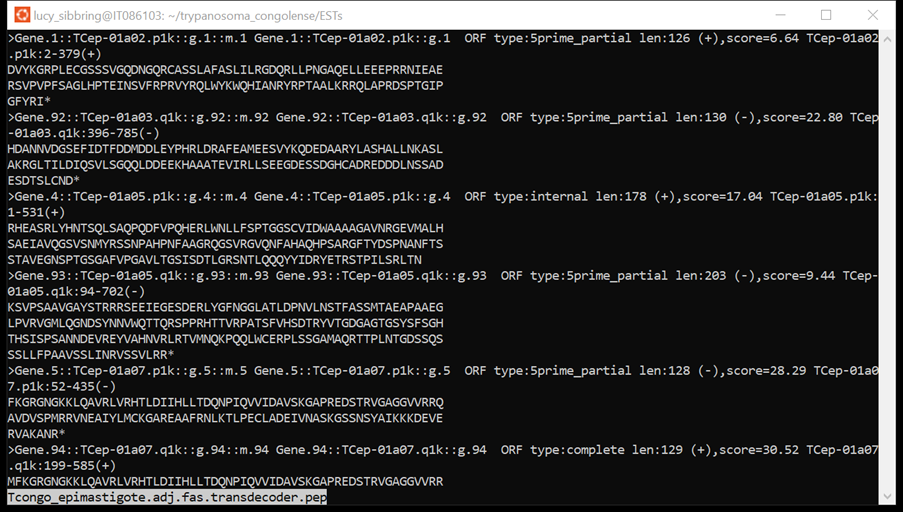

*Figure 5: protein coding sequences in Tcongo_epimastigote.adj.fas.transdecoder.pep*

# Renaming and Retrieval of the Predicted Coding Sequences 

`Tcongo_functions.py` is a python module we created containing the functions `rename_seq` and `retrieve_seq`: they rename the predicted coding sequences for the *T. congolense* life stages and retrieve a specific coding sequence using the ID number in a particular life cycle stage respectively. We added `Tcongo_functions.py` to our working directory (`ESTs`) in Ubuntu by opening the File Explorer (`explorer.exe .`) for this directory and pasting the python module in. 

To run these functions on the TransDecoder output files we used Python in Ubuntu. To access the Python command line in Ubuntu, we ran `python3` on the command line (Figure 6). To exit, press 'Ctrl D'.

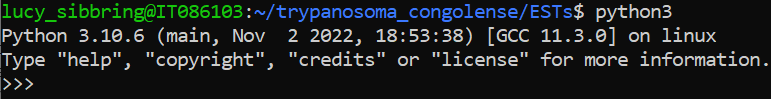

*Figure 6: Python command line in Ubuntu*

To call the functions into the Python environment, we ran `from Tcongo_functions import` followed by the functions name (Figure 7).

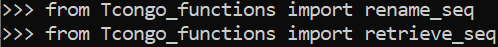

*Figure 7: calling the functions in the Python command line*

We ran the `rename_seq` function on the files from each life cycle stage with the ".adj.fas.transdecoder.pep" extension and this generated output files with the name now prefixed by "named_" (Figure 8).

Example: `rename_seq('Tcongo_epimastigote.adj.fas.transdecoder.pep')`

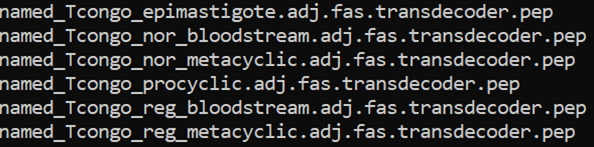

*Figure 8: output files from `rename_seq`*

Each ouput file contains numbered coding sequences for each life cycle stage (Figure 9). The numbering for sequences in each input file uses integers beginning at one and proceeds until the last coding sequence. The function was designed this way to improve human readability and because it was important to retain the knowledge of which life cycle stage the transcript originated from.

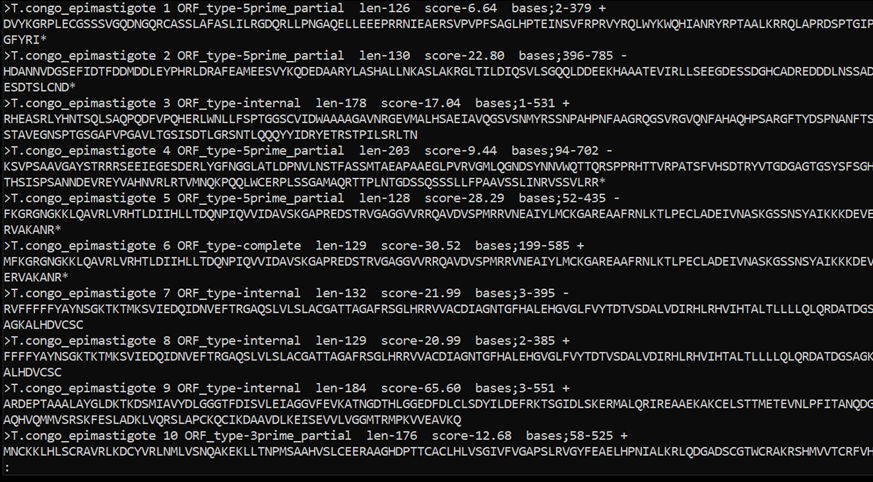

*Figure 9: numbered coding sequences for Tcongo_epimastigote.adj.fas.transdecoder.pep*

`rename_seq` formats the new coding sequence header as shown in Figure 9. It includes information on the ORF type, length, score, bases the sequence covers and the strand sense. These are included to help the user determine which sequences are of interest and want to analyse further. 

Retrieving sequences of interest can be done by passing the named file and the seqID number as arguments, `retrieve_seq('named_Tcongo_lifestage.adj.fas.transdecoder.pep', seqIDnumber)`, which produces an ouput fasta file with the name `Tcongo_lifestage_seqIDnumber.fas` (Figure 10).

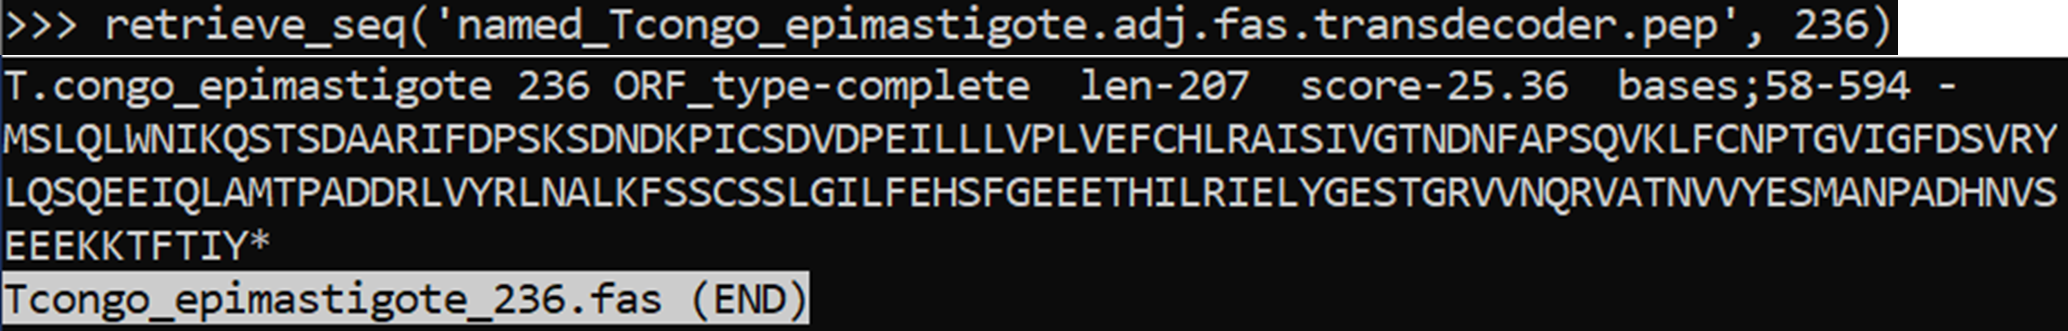

*Figure 10: `retrieve_seq` example for sequence 236 in the Tcongo epimastigote stage*

The `retrieve_seq` function has a built-in error message when a non-existent sequence ID number is passed which will notify users (Figure 11) and if this message does not appear, then the function has run as intended. 

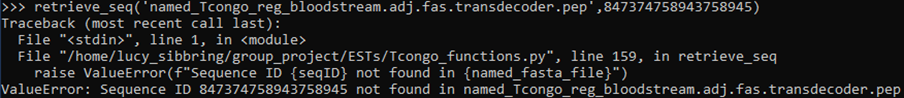

*Figure 11: error message for `retrieve_seq` when user enters seqID number that does not exist in the file*

# Results

Applying TransDecoder to the fasta files containing the EST data for each life cycle stage caused a decrease in the number of sequences reported, showing that between 44% and 62% of the original mRNA sequence fragments did not contain coding regions that could be recognised (Table 1). The regular bloodstream library contained the most predicted coding regions for the transcripts however the normalised metacyclic library, which was enriched for complete coding seqeunces, contained the most complete ORFs for the predicted coding regions; this means that both the 5' and 3' untranslated regions are present in the sequences, making them ideal for downstream high throughput analysis including genome annotation, gene discovery and proteomic analysis. Since we used the default parameters of TransDecoder, the minimum length of the amino acid sequences is 100 making it useful for BLAST analysis as this will reduce the number of false positive hits of the sequence. 

*Table 1: Trypanosoma congolense Number of Sequences for ESTs and Predicted Coding Regions*

Files| Procylic  | Epimastigote  | Regular Metacyclic  | Regular Bloodstream  | Normalised Metacyclic  | Normalised Bloodstream
------------- | -------------  | -------------  | -------------  | -------------  | -------------  | -------------
Tcongo_...adj.fas  | 4392   | 4451   | 3593   | 4214   | 4551   | 4585
Tcongo_...adj.fas.transdecoder.pep  | 2208   | 2280   | 1381   | 2370   | 2155   | 2304
Percentage coding sequences of original ESTs (%) | 50.3   | 51.2   | 38.4   | 56.2   | 47.4   | 50.3

Further analysis of these predicted coding regions from the ESTs can be streamlined by only considering sequences which scored the highest (log-likelihood score): the scores, across all the life stages, range from 0-370 so a good starting point for the best predicted coding regions, most likely to be the true coding genes, is 100 and above. The quickest way of identifying the highest scoring sequences is by using `grep` on the command line: `grep "score-[0-9][0-9][0-9]" named*` will look for the sequences which have a 3 digit score (i.e. 100 and over) across all of the fasta files produced as the ouput from the `rename_seq` function. From there, the unique seqID and life cycle stage can be passed as arguments into `retrieve_seq` and a fasta file produced with the desired sequence can be used for further analysis.

# Adapting Python Scripts for Future Datasets

The functions developed here for renaming and retrieving the *T. congolense* predicted coding sequences can be used easily on other *T. congolense* datasets which have been named in the same format: a case-insenstive letter code starting with "TC" and ending with two letters identifying the life cycle stage (e.g. "ep" for epimastigote), and "n" if derived from the normalised libraries. 

The use of the functions on different datasets requires editing them to reflect the nomenclature for the sequences in the datasets. This involves editing the regular expressions rules in `re.compile` and editing the names in the `for` parsing loop (Figure 12). This process shouldn't take too long though if the nomenclature is standardised for the dataset.

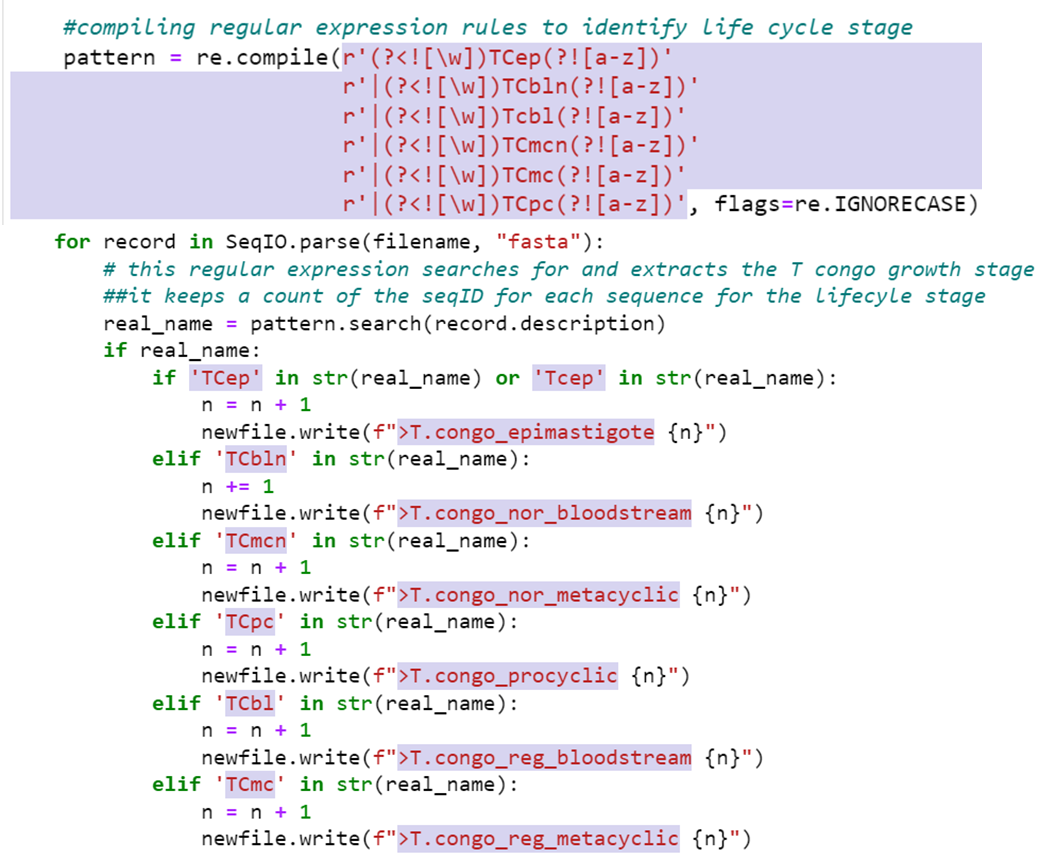

*Figure 12: highlighted sections of `rename_seq` that can be adapted to different datasets and this is likewise with `retrieve_seq`*

# Conclusion

Here we have shown you our approach to extract the coding regions from EST data derived from *T. congolense* and how to identify sequences within these fasta files of interest using functions developed in Python. The final output fasta files containing the sequence of interest have been designed to be easily passed into downstream analysis programmes, such as BLAST, to streamline the process. These approaches are easily applicable to future datasets involving *T. congolense* and can be manipulated to suit datasets from other species as mentioned above.

# Involvement of Each Author

Lucy Sibbring (2311385):
* Writing the rename_seq function
* Writing the retrieve_seq function
* Jupyter Notebook for Tutorial, Results Discussion and Adapting Python Scripts

Lucas Walker (1930864):
* Writing the rename_seq function
* Writing the retrieve_seq function
* Sourcing the code to replace "-" with "N" in the fasta files
* README
* Background and Introduction for Jupyter Notebook

Yilong Yang (2237985):
* Writing the rename_seq function
* Writing the retrieve_seq function
* Python consultant for the project
* Pipeline

# References

(1) Helm, J.R., Hertz-Fowler, C., Aslett, M., Berriman, M., Sanders, M., Quail, M.A., Soares, M.B., Bonaldo, M.F., Sakurai, T., Inoue, N. & Donelson, J.E. (2009) Analysis of expressed sequence tags from the four main developmental stages of Trypanosoma congolense. Molecular and Biochemical Parasitology. 168 (1), 34–42. doi:10.1016/j.molbiopara.2009.06.004

(2) Trypanosoma congolense - Wellcome Sanger Institute. https://www.sanger.ac.uk/resources/downloads/protozoa/trypanosoma-congolense.html [Accessed: 10 December 2022].

(3) Home · TransDecoder/TransDecoder Wiki. https://github.com/TransDecoder/TransDecoder/wiki [Accessed: 10 December 2022].